In [149]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [150]:
X_train = np.arange(0, 100, 0.5)
y_train = np.sin(X_train)

In [151]:
X_test = np.arange(100, 200, 0.5)
y_test = np.sin(X_test)

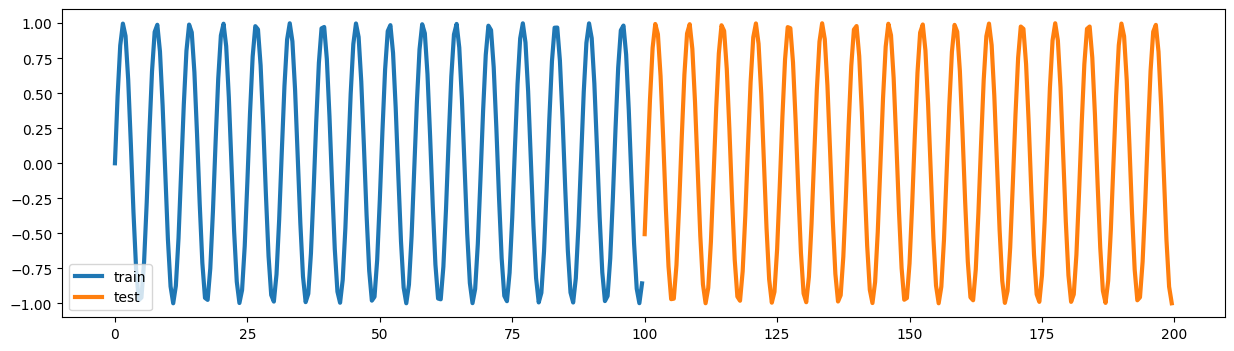

In [152]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(X_train, y_train, lw=3, label="train")
ax.plot(X_test, y_test, lw=3, label="test")
ax.legend(loc="lower left")
plt.show()

In [153]:
train_series = torch.from_numpy(y_train)
test_series = torch.from_numpy(y_test)

In [168]:
# LSTM expects input of (batch, sequence, features)
# So shape should be (1, 179, 20) and labels (1, 1, 179)
look_back = 20

train_dataset = []
train_labels = []
for i in range(len(train_series)-look_back):
    train_dataset.append(train_series[i:i+20])
    train_labels.append(train_series[i+20])
train_dataset = torch.stack(train_dataset).unsqueeze(0)
train_labels = torch.stack(train_labels).unsqueeze(0).unsqueeze(2)

In [169]:
class Net(nn.Module):
    def __init__(self, n_neurons, input_shape):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_shape, n_neurons)

        # TODO uncomment for LSTM
        # self.lstm = nn.LSTM(input_size=input_shape, hidden_size=n_neurons)
        self.fc = nn.Linear(n_neurons, 1)
    
    def forward(self, x):
        # TODO uncomment for LSTM
        # out, _ = self.lstm(x)
        out = self.fc1(x)
        out = self.fc(out)
        return out

In [170]:
n_neurons = 4

model = Net(n_neurons, look_back).double()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_curve = []
for epoch in range(300):
    loss_total = 0
    
    model.zero_grad()
    
    predictions = model(train_dataset)
    
    loss = loss_function(predictions, train_labels)
    loss_total += loss.item()
    loss.backward()
    optimizer.step()
    loss_curve.append(loss_total)

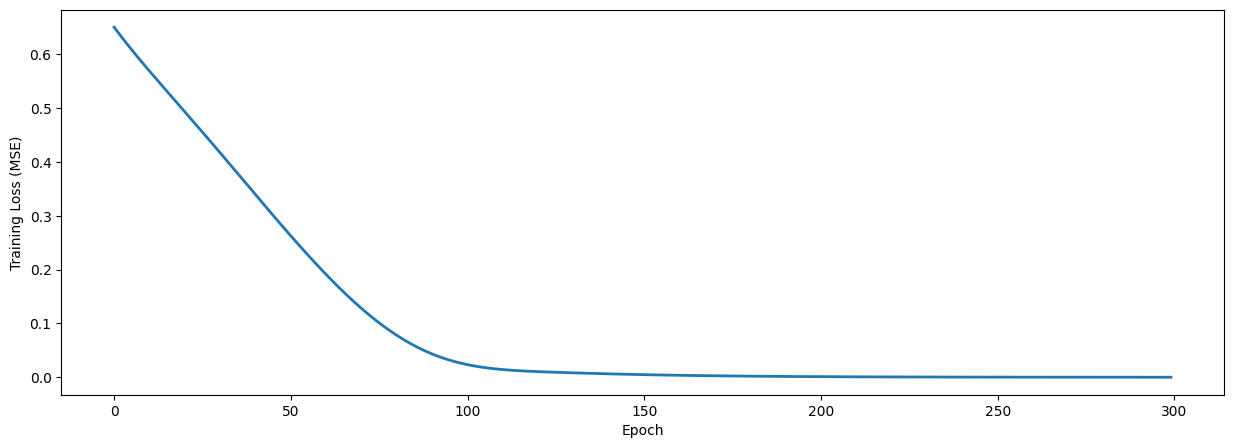

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(loss_curve, lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss (MSE)")
plt.show()

In [172]:
# LSTM expects input of (batch, sequence, features)
# So shape should be (1, 179, 20)
test_dataset = [test_series[i:i+20] for i in range(len(train_series)-look_back)]
test_dataset = torch.stack(test_dataset).unsqueeze(0)

with torch.no_grad():
    test_predictions = model(test_dataset).squeeze()

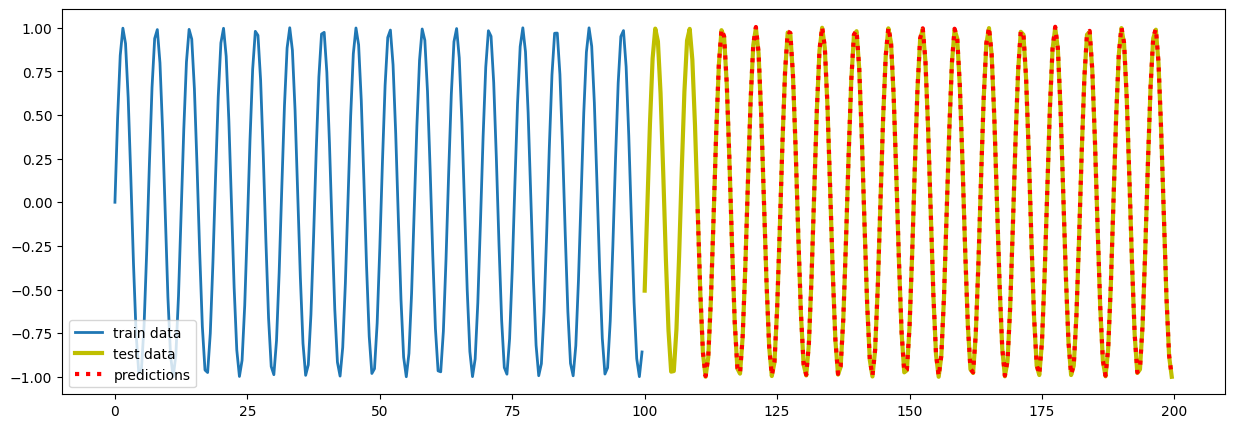

In [173]:
x = np.arange(110, 200, 0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test,y_test, lw=3, c='y', label='test data')
ax.plot(x,test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="lower left")
plt.show();

In [174]:
extrapolation = []
seed_batch = test_series[:20].reshape(1, 1, 20)
current_batch = seed_batch
with torch.no_grad():
    for i in range(400):
        predicted_value = model(current_batch)
        extrapolation.append(predicted_value.item())
        current_batch = torch.cat((current_batch[:,:,1:], predicted_value), axis=2)

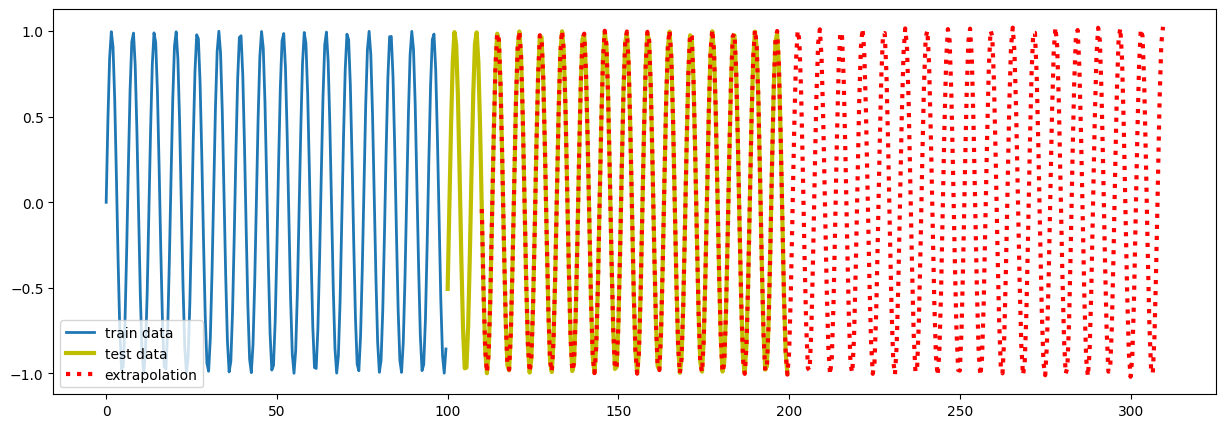

In [175]:
x = np.arange(110,310,0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test,y_test, lw=3, c='y', label='test data')
ax.plot(x,extrapolation, lw=3, c='r',linestyle = ':', label='extrapolation')
ax.legend(loc="lower left")
plt.show();